# SAS Viya for Learners Challenge 2024
## Introduction
In this project, we aim to build a predictive model for loan default using the `hmeq_train.csv` dataset. The main steps include data exploration, imputing missing data, handling outliers, feature selection, dimensionality reduction, model training, evaluation, and final predictions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from collections import Counter
import matplotlib.pyplot as plt

## Dataset Loading

In [2]:
# Load the training dataset
train_file_path = 'hmeq_train.csv'
hmeq_train_df = pd.read_csv(train_file_path)

In [3]:
# Load the test dataset
test_file_path = 'hmeq_test.csv'
hmeq_test_df = pd.read_csv(test_file_path)

### Displaying Dataset Information
We check the data types and non-null counts for each column.

In [4]:
# Display information about the dataframe
hmeq_train_df.info()
hmeq_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5198 entries, 0 to 5197
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5198 non-null   int64  
 1   default             5198 non-null   int64  
 2   loan_amount         5198 non-null   int64  
 3   mortgage_amount     4747 non-null   float64
 4   property_value      5103 non-null   float64
 5   loan_reason         4975 non-null   object 
 6   occupation          4957 non-null   object 
 7   occupation_length   4748 non-null   float64
 8   derogatory_reports  4579 non-null   float64
 9   late_payments       4695 non-null   float64
 10  oldest_credit_line  4931 non-null   float64
 11  recent_credit       4762 non-null   float64
 12  credit_number       5002 non-null   float64
 13  ratio               4085 non-null   float64
dtypes: float64(9), int64(3), object(2)
memory usage: 568.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIn

## Data Exploration
### Displaying the First Few Rows
We first explore the datasets by displaying the first few rows.

In [5]:
# Display the first few rows of the dataframe
hmeq_train_df.head()

,id,default,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,16537,0,20900,58299.0,78684.00,DebtCon,NaN,3.0,0.0,0.0,98.662820,0.0,16.0,38.972004
1,14800,0,17400,56111.0,114521.00,HomeImp,Office,2.0,NaN,2.0,154.855524,1.0,24.0,38.695084
2,11317,0,8700,57254.0,86883.00,HomeImp,Other,16.0,0.0,0.0,172.166563,0.0,28.0,25.043437
3,13023,0,6000,69876.0,94394.07,HomeImp,Other,0.0,0.0,1.0,179.566667,0.0,32.0,NaN
4,11652,0,9700,75566.0,92066.00,DebtCon,Office,14.0,0.0,0.0,94.987922,0.0,8.0,25.161183


In [6]:
# Display the first few rows of the dataframe
hmeq_test_df.head()

,id,loan_amount,mortgage_amount,property_value,loan_reason,occupation,occupation_length,derogatory_reports,late_payments,oldest_credit_line,recent_credit,credit_number,ratio
0,12816,28100,32470.0,54522.0,DebtCon,Other,35.0,0.0,0.0,295.496684,0.0,23.0,38.799483
1,11678,10500,57880.0,66802.0,DebtCon,Other,2.0,0.0,0.0,94.598425,8.0,21.0,45.464766
2,13568,10900,NaN,76207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.392612
3,16525,50000,44000.0,59000.0,DebtCon,Office,12.0,0.0,1.0,102.500000,2.0,26.0,NaN
4,16160,7500,NaN,26850.0,HomeImp,Office,20.0,0.0,0.0,185.633333,1.0,16.0,NaN


## Data Preprocessing

### Label Encoding
We apply label encoding to the `loan_reason` column and `occupation` column.

In [7]:
# Apply Label Encoding to 'loan_reason' and 'occupation'
loan_reason_le = LabelEncoder()
occupation_le = LabelEncoder()

hmeq_train_df['loan_reason'] = loan_reason_le.fit_transform(hmeq_train_df['loan_reason'].astype(str))
hmeq_train_df['occupation'] = occupation_le.fit_transform(hmeq_train_df['occupation'].astype(str))

hmeq_test_df['loan_reason'] = loan_reason_le.transform(hmeq_test_df['loan_reason'].astype(str))
hmeq_test_df['occupation'] = occupation_le.transform(hmeq_test_df['occupation'].astype(str))

In [8]:
# Separate features and target variable
X = hmeq_train_df.drop(columns=['id', 'default'])
y = hmeq_train_df['default']
X_test_final = hmeq_test_df.drop(columns=['id'])

## Handling Missing Data

### Imputing Missing Values
We use the `SimpleImputer` with the median strategy to fill missing values.

In [9]:
# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

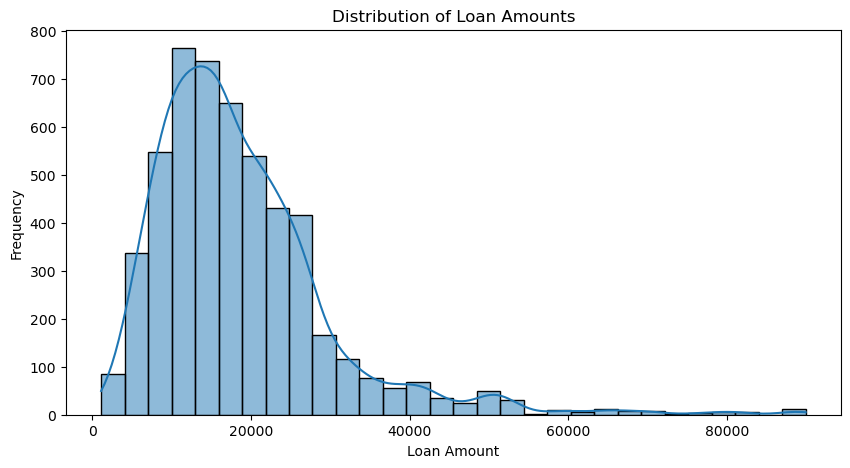

In [10]:
# Distribution of Loan Amounts
plt.figure(figsize=(10, 5))
sns.histplot(hmeq_train_df['loan_amount'], bins=30, kde=True)
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

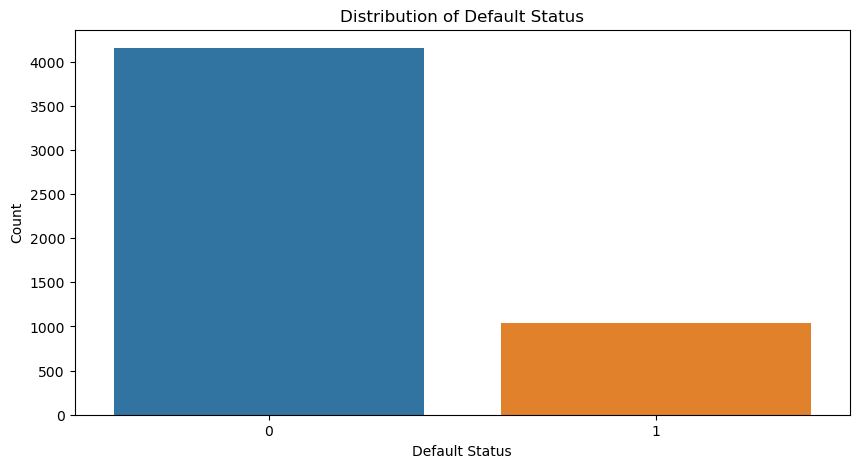

In [11]:
# Distribution of Default Status
plt.figure(figsize=(10, 5))
sns.countplot(x='default', data=hmeq_train_df)
plt.title('Distribution of Default Status')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.show()

## Feature Scaling and Dimensionality Reduction

### Scaling Features Using MinMaxScaler
We scale the features to a range of [0, 1] using `MinMaxScaler`.

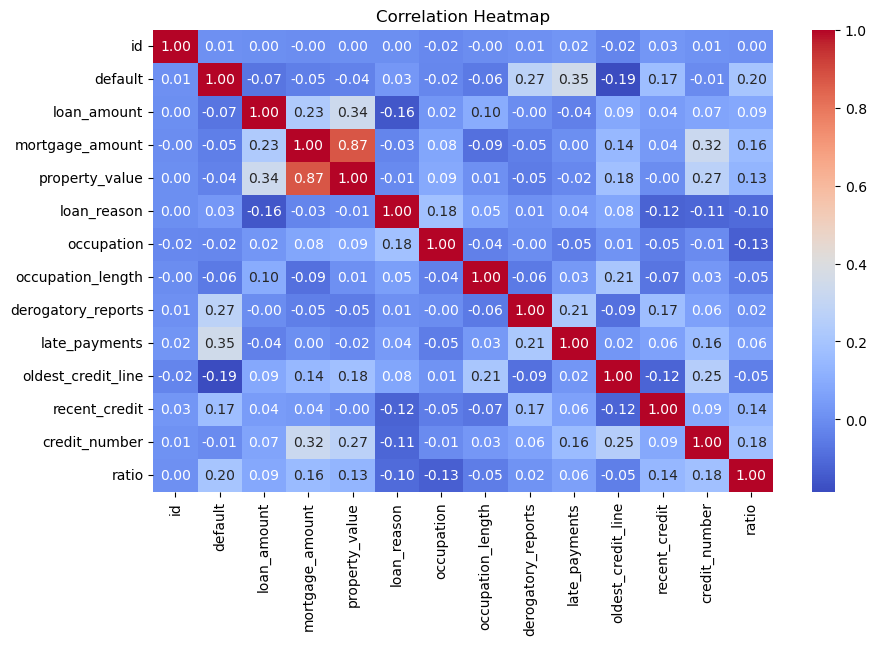

In [12]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(hmeq_train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)
X_test_final_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test_imputed.columns)

# Determine the number of features
n_features = X_scaled.shape[1]

In [14]:
# Apply PCA
pca = PCA(n_components=min(n_features, 10))  # Set n_components to the minimum of n_features and a chosen value
X_pca = pca.fit_transform(X_scaled)
X_test_final_pca = pca.transform(X_test_final_scaled)

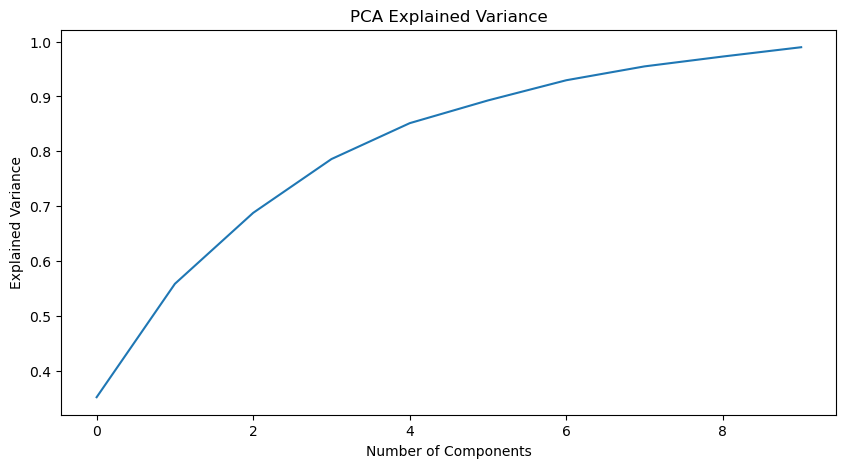

In [15]:
# PCA Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

## Feature Selection Using RFE

### Recursive Feature Elimination
We use Recursive Feature Elimination (RFE) with logistic regression to select the top features.

In [16]:
# Feature Selection using RFE
log_reg = LogisticRegression(random_state=42)
rfe = RFE(estimator=log_reg, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_pca, y)
X_test_final_rfe = rfe.transform(X_test_final_pca)

## Model Training and Evaluation

### Train-Test Split
We split the data into training and testing sets.

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3, random_state=42)

### Handling Class Imbalance Using SMOTE
We use Synthetic Minority Over-sampling Technique (SMOTE) to balance the classes.

Class distribution before SMOTE: Counter({0: 2906, 1: 732})
Class distribution after SMOTE: Counter({0: 2906, 1: 2906})


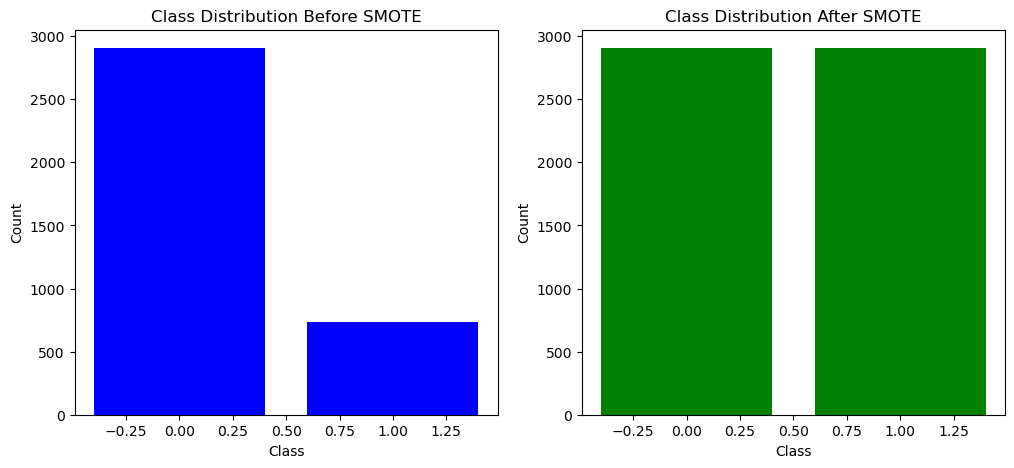

In [18]:
# Check the class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_train_smote))

# Plot the class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
axes[0].bar(Counter(y_train).keys(), Counter(y_train).values(), color='blue')
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# After SMOTE
axes[1].bar(Counter(y_train_smote).keys(), Counter(y_train_smote).values(), color='green')
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.show()

### Training and Evaluating Models
We train and evaluate different models including KNN, RandomForest, XGBoost, and Stacking Classifier.

In [19]:
# Function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    return accuracy, conf_matrix, class_report

In [20]:
# Define the models
best_knn = KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean', n_neighbors=1, weights='uniform')
best_rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
best_xgb = xgb.XGBClassifier(colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=9, n_estimators=500, reg_alpha=0.01, reg_lambda=1, subsample=0.8)

# Create the stacking classifier
estimators = [
    ('knn', best_knn),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

In [21]:
# Initialize the stacking classifier with the best-found parameters for Logistic Regression
stacking_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(
        C=10,
        max_iter=300,
        penalty='l2',
        solver='saga'
    )
)

# Evaluate the stacking classifier
stack_accuracy, stack_conf_matrix, stack_class_report = evaluate_model(stacking_classifier, X_train_smote, X_test, y_train_smote, y_test)

# Print the results
print(f"Stacking Classifier Accuracy: {stack_accuracy}")
print("Confusion Matrix:")
print(stack_conf_matrix)
print("Classification Report:")
print(stack_class_report)

Stacking Classifier Accuracy: 0.9519230769230769
Confusion Matrix:
[[1242    8]
 [  67  243]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1250
           1       0.97      0.78      0.87       310

    accuracy                           0.95      1560
   macro avg       0.96      0.89      0.92      1560
weighted avg       0.95      0.95      0.95      1560



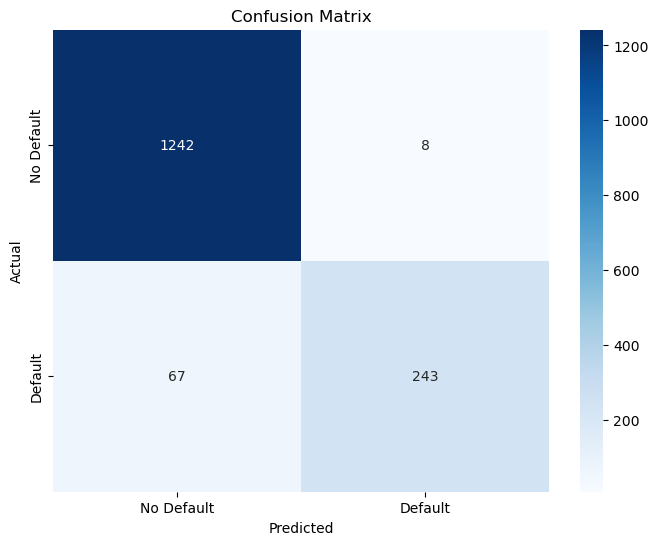

In [22]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(stack_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Cross-Validation
We perform cross-validation to evaluate the robustness of our model.

In [23]:
# Define the number of folds
k_folds = 5

# Perform cross-validation
cv_scores = cross_val_score(stacking_classifier, X_rfe, y, cv=k_folds, scoring='accuracy', n_jobs=-1)

# Print cross-validation scores
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of CV Score: {np.std(cv_scores)}")

# Print detailed cross-validation results
cv_results = pd.DataFrame(cv_scores, columns=['Accuracy'])
cv_results['Fold'] = range(1, k_folds + 1)
print(cv_results)

Cross-Validation Scores: [0.95192308 0.97019231 0.95865385 0.95668912 0.96246391]
Mean CV Score: 0.959984452506108
Standard Deviation of CV Score: 0.006131288340315996
   Accuracy  Fold
0  0.951923     1
1  0.970192     2
2  0.958654     3
3  0.956689     4
4  0.962464     5


## Final Predictions and Submission

### Generating Predictions for Test Set
We generate predictions using the trained stacking classifier and prepare the submission file.

In [24]:
# Generate predictions using the trained stacking classifier
test_predictions = stacking_classifier.predict(X_test_final_rfe)

# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'id': hmeq_test_df['id'],
    'default': test_predictions
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)